# Lab 7: Computer Vision Applications - Segmentation

In this lab session, you will:
1. learn how to train and use a network for segmentation
2. fine-tune a model for object detection
3. learn how to do instance segmentation using Mask R-CNN

## Training from scratch

In this part, we will implement a [Fully Convolutional Network (FCN)](https://arxiv.org/pdf/1605.06211.pdf) and train it from scratch.
Due to the large-scale dataset, the training processing is very time consuming based on CPU, you can try this on GPU.

In [ ]:
# install d2l
!pip install -U d2l
from d2l import torch as d2l

In [ ]:
# import some basic libaries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models
from sklearn.metrics import accuracy_score
import cv2
from PIL import Image
from tqdm import tqdm
import warnings
import os

###  Dataset
Pytorch provides Dataset and Data Loader to help process datasets. For the training data of semantic segmentation, assume that we already have the original image and the corresponding label image. In order to train the network model, we need the Tensor data of the original image, with shape (N, C, H, W). Where N is the number of samples, C is the number of channels, H and W represent the pixel height and width of the image. At the same time, it is necessary to ensure that all training images have the same C, H and W. Label data can use standard labels of (N, H, W) shape, or use one-hot encoding labels

In this practical, we will use one of the most important datasets for semantic segmentation: [Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).
We use the d2l package to download and extract the dataset.

In [ ]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

You can access the path `../data/VOCdevkit/VOC2012` to check the structure and the different components of the dataset.

The `ImageSets`/`Segmentation` path contains the text files for the training and test samples, while the `JPEGImages` and `SegmentationClass` paths store the input images and labels for each example, respectively. The label here also uses image format, with the same dimensions as the input image it annotates. Furthermore, pixels with the same color in the label belong to the same semantic category.

The code below will read a few images (not all) for training and testing.

In [ ]:
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC images and label them"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB # Read RGB images
    with open(txt_fname, 'r') as f:
        filenames = f.read().split() # image name
    images, labels = [], []
    for i, fname in enumerate(filenames):
        images.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode)) # RGB labels
    return images[:500], labels[:500]

# since the VOC is a large dataset, we choose the first 500 data for train and test
train_images, train_labels = read_voc_images(voc_dir, True)

print(len(train_images))

Next we plot the first `5 ` input images and their labels. In the label image, white and black represent border and background respectively, while other colors correspond to different categories

In [ ]:
n = 10
imgs = train_images[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

The RGB color value and respective class name. (the readme file in the data set will tell you this information)

In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

With the two constants defined above, we can conveniently look up the class index of each pixel in the label. The `voc_colormap2label` function below builds a mapping from the above RGB color values to category indices, and the `voc_label_indices` function maps RGB values to category indices.

In [ ]:
def voc_colormap2label():
    """Build a mapping from RGB to VOC category index (labels)"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        # Convert the index in VOC_COLORMAP to i
        # Change the 256 base to the 10 base
        # Map the i-th RGB value to i
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label # a dict

# Colormap is the RGB value in the image, which is converted into the corresponding label value
def voc_label_indices(colormap, colormap2label):
    """Map RGB values in VOC labels to their category indices"""
    # permute(1, 2, 0) to trans between the channels
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

For example, the category index of the aeroplane head area is 1, while the background index is 0

In [ ]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

The original image data does not always meet the standards of data processing requirements. The different networks we use also have different types and required input data formats, so we need to preprocess the data. Here, we mainly use the data transformation function in data preprocessing. We divide the processing into two stages:
1. image loading stage, and
2. data preprocessing stage.

In the image loading stage, we face problems such as different size of the read images, aspect ratio, different image formats, and data differences brought about by different image processing libraries. Correspondingly, a series of preprocessing operations such as scaling, cutting, format conversion, and dimension transformation are required.

For image loading stage, we first define a function to crop the images and the labels to a fixed size.

In [ ]:
def voc_rand_crop(image, label, height, width):
    """Randomly crop images and labels"""
    # i,j,h,w get the bounding box ，that is, in which area to crop
    i,j,h,w = transforms.RandomCrop.get_params(
        image, output_size=(height, width))
    image = transforms.functional.crop(image, i,j,h,w)
    label = transforms.functional.crop(label, i,j,h,w)
    return image, label  # cropped images and labels

In [ ]:
# visualization about the crop
imgs = []
for _ in range(n):
  # randomly select a size of 224x224 to crop
    imgs += voc_rand_crop(train_images[1], train_labels[1], 224, 224)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In the data processing stage, we need to normalize the data to improve the convergence speed. [torchvison.transorm](https://pytorch.org/vision/0.9/transforms.html) provides a [Normalize function](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Normalize), which performs the [z-score normalization](https://en.wikipedia.org/wiki/Standard_score) and requires two parameters: the mean (mean) and standard deviation (std).

Since the data is encoded as `uint8` (that is, each pixel has value between 0 and 255), we directly use the maximum value of the color, 255, as the divisor to directly normalize the Tensor data. For the [Normalize function](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Normalize), we use the mean and standard deviation calculated using the images of the ImageNet dataset (it is common to do this).

We then define the Dataset class to complete the two preprocessing stages:

In [ ]:
class VOCSegDataset(torch.utils.data.Dataset):
    """For loading the VOC dataset"""
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = (
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # normalization
            )
        self.crop_size = crop_size
        # read images
        images, labels = read_voc_images(voc_dir, is_train=is_train)  # 500 images
        self.images = [self.normalize_image(image) for image in self.filter(images)]
        self.labels = self.filter(labels)  # filter is defined later
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.images)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)  # dividing by 255 and normalize

    def filter(self, imgs):
        # remove the image if the szie is smaller than the area to crop
        # this will probably filter out some images from the 500
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        image, label = voc_rand_crop(self.images[idx], self.labels[idx], *self.crop_size)
        return (image, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.images)

Create the train dataset and test dataset, and set the crop size as `224x224`.

In [ ]:
crop_size = (224, 224)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

Pytorch uses the DataLoader to access the dataset indirectly. We then create our training loader and testing loader.

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(voc_train, batch_size,
                                           shuffle=True, drop_last=True)

for X, Y in train_loader:
    print(X.shape)  # 4 dimensions batch, 3-RGB, height, width
    print(Y.shape)  # the labels here are three-dimensional array
    break

In [ ]:
test_loader = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True)

### Implementing the model

Unlike traditional CNNs, FCN uses convolutional layers instead of fully connected (FC) layers in CNNs, so that all layers in the entire network structure are convolutional layers. The main techniques used in FCN include: Convolutional, Strided Convolution, Skip Layer, Downsampling (Pooling in CNN) and Upsampling.

FCN scales the data size to ```1/32``` of the original image size through multiple downsampling operations. The feature information of the original image is lost during the neural network transmission process, resulting in a loss of accuracy in the prediction results. In response to this problem, the final scoring strategy of FCN is divided into direct scoring, combined scoring with the last Downsampling result, and joint scoring with the last two Dowsamping results, which are called `FCN-32s`, `FCN-16s` and `FCN-8s` respectively.

Among them, `FCN-8s` (c in the image below) uses the results of the first two downsamplings, so the accuracy of the final predicted results is usually higher than that of `FCN-16s` (b) and `FCN-32s` (a).

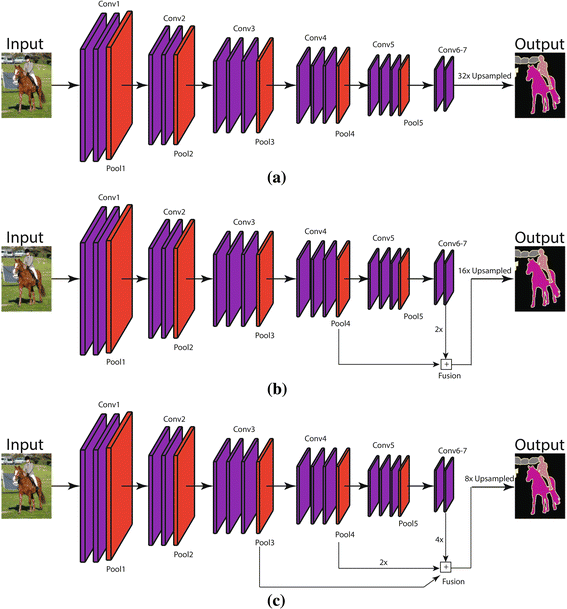

We will implement classic FCN-8s model with Pytorch.

The network model is mainly divided into three parts:
1. the initial convolutional layers (responsible for extracting the features),
2. the convolutional layer that replaces the fully connected layer, and
3. the upsampling layer.

We first give the complete code of the network and then explain some parts.

In [ ]:
#  define the FCN8s module
class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s, self).__init__()
        self.num_classes = num_classes
        # The first layer of convolution
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 48, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/2
        )

        # The second layer of convolution
        self.layer2 = nn.Sequential(
            nn.Conv2d(48, 128, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/4
        )

        # The third layer of convolution
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 192, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/8
        )

        # The fourth layer of convolution
        self.layer4 = nn.Sequential(
            nn.Conv2d(192, 256, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/16
        )

        # The fifth layer of convolution
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/32
        )

        # The sixth layer uses a 1x1 convolutional layer to replace the FC layer
        # these 3 convolution layers generate the prediction - that's why they use num_classes
        self.score_1 = nn.Conv2d(512, num_classes, (1, 1))
        self.score_2 = nn.Conv2d(256, num_classes, (1, 1))
        self.score_3 = nn.Conv2d(192, num_classes, (1, 1))

        # Deconvolution layers (upsampling_2x is equal to upsampling_4x)
        self.upsampling_2x = nn.ConvTranspose2d(num_classes, num_classes, (4, 4), (2, 2), (1, 1), bias=False)
        self.upsampling_4x = nn.ConvTranspose2d(num_classes, num_classes, (4, 4), (2, 2), (1, 1), bias=False)
        self.upsampling_8x = nn.ConvTranspose2d(num_classes, num_classes, (16, 16), (8, 8), (4, 4), bias=False)

        self._initialize_weights()

    # Bilinear interpolation weight initialization, used for deconvolutional layer
    @staticmethod
    def bilinear_kernel(in_channels, out_channels, kernel_size):
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
              # xavier weight initialization for convolutional layers
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.bilinear_kernel(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.layer1(x) # 1/2
        h = self.layer2(h) # 1/4
        s1 = self.layer3(h) # 1/8
        s2 = self.layer4(s1) # 1/16
        s3 = self.layer5(s2) # 1/32

        s3 = self.score_1(s3)  # generate prediction
        s3 = self.upsampling_2x(s3)  # deconvolution 1/16
        s2 = self.score_2(s2)  # generate prediction
        s2 += s3  # add
        s2 = self.upsampling_4x(s2)  # 1/8
        s1 = self.score_3(s1)  # prediction
        score = s1 + s2  # add
        score = self.upsampling_8x(score) # restore to the original size

        return score


We have 5 convolutional layers to extract features, 3 layers to generate prediction, and 3 transposed convolutions to upsample the data and produce the final outcome.
For the feature extraction part, we reduced the number of layers and neurons (when compared to the original network) to speed up the training process.

We also have some auxiliary functions to initialize the layer weights.
Weight initialization involves initializing default values for the neurons of the convolutional and deconvolutional layers. If the network model is a known model, such as VGG or ResNET, then the default weight values are usually initialized with pre-trained parameters. We use our own modified network model, so here we manually initialize the weights.

For the weight initialization of the convolution layer, the [xavier initialization method](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_) is used, and the weight initialization of the deconvolution layer uses the Bilinear interpolation algorithm.

Weight initialization is important here. If it is not handled properly, gradient disappearance or gradient explosion may occur during backpropagation, and the gradient cannot even be calculated.

In [ ]:
#  create a model
model=FCN8s(num_classes=21)
model

### Training

In order to train the network model, we need to focus on the following aspects: `learning criteria`, `optimization` and `metrics`.

In [ ]:
# multi-classification cross-entropy loss function
lossf = nn.CrossEntropyLoss()

# choose adam optimizer to train
optimizer = optim.SGD(model.parameters(),lr=0.1)

epochs_num = 10

The training function is implemented below.
You need to connect to the GPU in colab first.

In [ ]:
def train_batch(net, X, y, loss, trainer, device):
    """Train for a minibatch with GPU """
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train(net, train_iter, test_iter, loss, trainer, num_epochs):
    #Train a model using GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    timer, num_batches = d2l.Timer(), len(train_iter)

    net = net.to(device)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_loader):
            timer.start()
            l, acc = train_batch(net, features, labels.long(), loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        print(f'epoch {epoch+1} -- '
              f'loss {metric[0] / metric[2]:.3f}, train acc '
              f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f} ------ '
              f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
              f'{str(device)}')

# this process is very time consuming, please use the gpu to improve the efficiency.
train(model, train_loader, test_loader, lossf, optimizer, epochs_num)

The result is not very good, we only get `60+%` accuracy. We can improve this by just initializing the network using a pre-trained model (aka, fine-tuning).



## Using a pre-trained model / Fine-tuning

Let's implement a semantic segmentation model based on the pretrained model.

Now before we get started, let's just recap the inputs and outputs of these semantic segmentation models.<br/>

These models expect a 3-channeled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`.

So, the input is `[N_in x C_in x H_in x W_in]`, <br/>
where,
- `N_in` -> the batch size
- `C_in` -> the number of channels (which is 3)
- `H_in` -> the height of the image
- `W_in` -> the width of the image

And the output of the model is `[N_out x C_out x H_out x W_out]`, <br/>
where,
- `N_out` -> is the batch size (same as `N_in`)
- `C_out` -> **is the number of classes that the dataset have!**
- `H_out` -> the height of the image (which is the same as `H_in` in almost all cases)
- `W_out` -> the width of the image (which is the same as `W_in` in almost all cases)

Note: Remember that `C_out` is the number `21` for the [Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) semantic image segmentation benchmark.

Alright! And just one more thing!
The `torchvision` models outputs an `OrderedDict` and not a `torch.Tensor` <br/>
And in `.eval()` mode it just has one key `out` and thus to get the output we need to get the value stored in that `key`.

The `out` key of this `OrderedDict` is the key that holds the output. <br/>
So, this `out` key's value has the shape of `[N_out x C_out x H_out x W_out]`. More documentation can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

Now! we are ready to play.

### Fine-tuning

Importing the pre-trained FCN.

In [ ]:
from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights
# from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

# this is the pre-trained weights we want to use
# this model was pre-trained using a subset of the COCO dataset [https://cocodataset.org/]
# with 21 classes (the same ones of the VOC PASCAL)
weights = FCN_ResNet101_Weights.DEFAULT
fcn = fcn_resnet101(weights=weights, progress=False)  # this is the model

For the model in PyTorch, you can refer the [website1](https://pytorch.org/vision/stable/models/fcn.html) for more details.

And that's it! We have a pretrained model of `FCN` with a `Resnet101` backbone.

Let's check using the same dataset as before.

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(voc_train, batch_size,
                                           shuffle=True, drop_last=True)

for X, Y in train_loader:
    print(X.shape)  # 4 dimensions batch, 3-RGB, height, width
    print(Y.shape)  # the labels here are three-dimensional array
    break

In [ ]:
test_loader = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True)

In [ ]:
# multi-classification cross-entropy loss function
lossf = nn.CrossEntropyLoss()

# choose adam optimizer to train
optimizer = optim.SGD(fcn.parameters(), lr=0.1)

epochs_num = 10

In [ ]:
def train_batch(net, X, y, loss, trainer, device):
    """Train for a minibatch with GPU """
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred['out'], y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred['out'], y)
    return train_loss_sum, train_acc_sum

def evaluate(net, test_iter, device):
    net.eval()
    acc = []
    for i, (features, labels) in enumerate(test_iter):
        X = features.to(device)
        pred = net(X)
        soft_outs = F.log_softmax(pred['out'], dim=1)
        pred = soft_outs.cpu().data.numpy().argmax(axis=1)  # argmax preserves the index of the maximum value
        acc.append(accuracy_score(labels.flatten(), pred.flatten()))
    return sum(acc)/len(acc)

def train(net, train_iter, test_iter, loss, trainer, num_epochs):
    #Train a model using GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    timer, num_batches = d2l.Timer(), len(train_iter)

    net = net.to(device)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_loader):
            timer.start()
            l, acc = train_batch(net, features, labels.long(), loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()

        test_acc = evaluate(net, test_iter, device)
        print(f'epoch {epoch+1} -- '
              f'loss {metric[0] / metric[2]:.3f}, train acc '
              f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f} ------ '
              f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
              f'{str(device)}')

# this process is very time consuming, please use the gpu to improve the efficiency.
train(fcn, train_loader, test_loader, lossf, optimizer, epochs_num)

Now we can get around 80% of accuracy.

Let's use this model for inference now.

### Inference

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the helper function - from class to RGB
def decode_segmap(image, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

def segment(net, path, show_orig=True, dev= device):
  img = Image.open(path)  # open original image
  # plot original image
  img = img.convert("RGB")
  if show_orig:
    plt.imshow(img);
    plt.axis('off');
    plt.show()

  # Resize and normalize
  trf = transforms.Compose([transforms.Resize(256), # Resize the image to (256 x 256)
                          transforms.ToTensor(),
                          transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                               std = [0.229, 0.224, 0.225])])

  # we unsqueeze the image so that it becomes [1 x C x H x W] from [C x H x W]
  # we need a batch dimension while passing it to the models
  inp = trf(img).unsqueeze(0).to(dev)

  # network inference
  out = net.to(dev)(inp)['out']

  # get the 2D output image - CLASSES x H X W
  # then, using argmax, we preserve the index of the max value (per pixel)
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)  # from integer classes to RGB

  plt.imshow(rgb);
  plt.axis('off');
  plt.show()

In [ ]:
# Download an example image from the internet - feel free to change this to use another image
import urllib
url, filename = ("https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg", "bird.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

segment(fcn, path="bird.png")